# Deep Learning hw3
2018131605 원종빈

## 20.1. GAN

In [36]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
X = torch.normal(0.0, 1, (1000,2))
A = torch.tensor([[1,2],[-0.1, 0.5]])
b = torch.tensor([1,2])

data = X @ A + b

tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


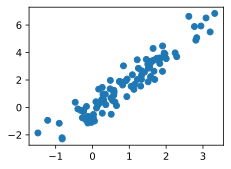

In [38]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy())
print(torch.matmul(A.T, A))

In [39]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [40]:
net_G = nn.Sequential(nn.Linear(2,2))

net_D = nn.Sequential(nn.Linear(2,5), nn.Tanh(),
                      nn.Linear(5,3), nn.Tanh(),
                      nn.Linear(3,1))

In [41]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    
    trainer_D.zero_grad()
    
    fake_X = net_G(Z)
    real_Y = net_D(X)
    fake_Y = net_D(fake_X.detach())
    
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape))
              + loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    
    loss_D.backward()
    trainer_D.step()
    
    return loss_D

In [42]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)
    
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    
    return loss_G

In [43]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 0.694, loss_G 0.695, 1361.6 examples/sec


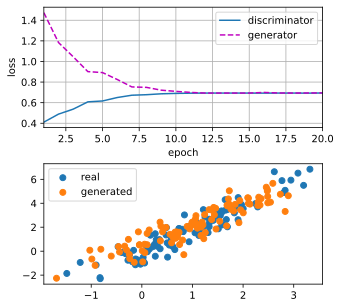

In [44]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20

train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())

## 20.2. DCGAN

In [1]:
import warnings
import torch, torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [3]:
batch_size = 256

transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size, shuffle=True,
    num_workers=1
)

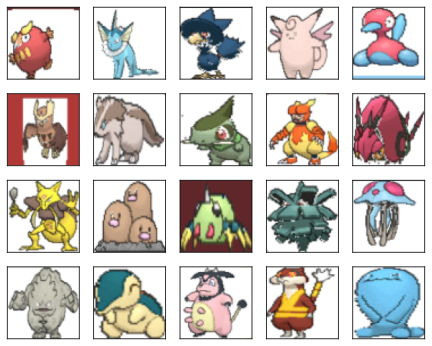

In [4]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4,4))

for X, y in data_iter:
    imgs = X[:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [5]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
        super().__init__()
        
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))
    

X = torch.zeros((2,3,16,16))
g_blk = G_block(20)
g_blk(X).shape

torch.Size([2, 20, 32, 32])

In [6]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8, strides=1, padding=0),        
    G_block(in_channels=n_G*8, out_channels=n_G*4),
    G_block(in_channels=n_G*4, out_channels=n_G*2),
    G_block(in_channels=n_G*2, out_channels=n_G*1),
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

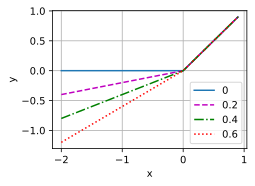

In [9]:
## leaky ReLU
alphas = [0, .2, .4, .6, .8, 1]
X = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(X.detach().numpy(), Y, 'x', 'y', alphas)

In [10]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [13]:
X = torch.zeros((2,3,16,16))
d_blk = D_block(20)
d_blk(X).shape

torch.Size([2, 20, 8, 8])

In [17]:
n_D = 64

net_D = nn.Sequential(
    D_block(n_D),
    D_block(in_channels=n_D*1, out_channels=n_D*2),
    D_block(in_channels=n_D*2, out_channels=n_D*4),
    D_block(in_channels=n_D*4, out_channels=n_D*8),
    nn.Conv2d(n_D*8, 1, kernel_size=4, bias=False))

X = torch.zeros((1,3,64,64))
net_D(X).shape

torch.Size([1, 1, 1, 1])

0.08798618210000111 7.851842714165879
1232.1092977666653


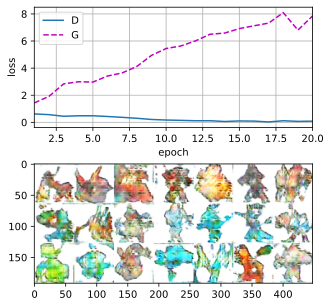

In [20]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)    
    
    net_D, net_G = net_D.to(device), net_G.to(device)
    
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}  ## hyper parameters
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], nrows=2, figsize=(5,5), legend=['D', 'G'])
    animator.fig.subplots_adjust(hspace=0.3)
    
    for epoch in range(1, num_epochs+1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
            
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        fake_X = net_G(Z).permute(0,2,3,1) / 2 + 0.5
        imgs = torch.cat([torch.cat([fake_X[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
                          for i in range(len(fake_X) // 7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    
    print(loss_D, loss_G)
    print(metric[2] / timer.stop())
        
        
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)  